In [98]:
from FHN_PDE_Simulator import FHN_PDE_Simulator as pde_sim # PDE Simulator
from ode_surrogate import fhn_ode_surrogate as ode_sim # ODE surrogate model

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, morris as morris_sample
from SALib.analyze import sobol, morris
import time
import pandas as pd

In [99]:
problem = {
    'num_vars': 5,
    'names': ['Du','Dv','a','b','epsilon'],
    'bounds': [[0.8, 1.2],
               [0.0, 1.0],
               [0.05, 0.15],
               [0.2, 0.7],
               [0.001, 0.02]]
}

In [100]:
# PDE metric computation
from SALib.sample import morris as morris_sampler
from SALib.sample import saltelli

import numpy as np

def run_pde_and_metrics(params: dict, size=60, steps=1600, snapshot_interval=20, solver='euler'):
    sim = pde_sim(size=size, solver=solver, **params)
    sim.set_initial_conditions('spiral_obstacle')
    # Collect spatial mean every snapshot
    history_u = []
    history_v = []
    for step in range(steps):
        sim.step()
        if step % snapshot_interval == 0:
            history_u.append(sim.u.mean())
            history_v.append(sim.v.mean())
    u_arr = np.array(history_u)
    v_arr = np.array(history_v)
    amp_u = u_arr.max() - u_arr.min()
    amp_v = v_arr.max() - v_arr.min()
    var_u = u_arr.var()
    var_v = v_arr.var()
    return amp_u, var_u, amp_v, var_v, u_arr, v_arr


def evaluate_pde_samples(X, names):
    amp_u_list = []
    var_u_list = []
    amp_v_list = []
    var_v_list = []
    for row in X:
        params = dict(zip(names, row))
        amp_u, var_u, amp_v, var_v, _, _ = run_pde_and_metrics(params)
        amp_u_list.append(amp_u)
        var_u_list.append(var_u)
        amp_v_list.append(amp_v)
        var_v_list.append(var_v)
    return {
        'amp_u': np.array(amp_u_list),
        'var_u': np.array(var_u_list),
        'amp_v': np.array(amp_v_list),
        'var_v': np.array(var_v_list)
    }

In [101]:
# Sobol (Saltelli) sampling & analysis for PDE metrics

N = 16
X_sobol = saltelli.sample(problem, N, calc_second_order=True)
print(f"Generated Saltelli sample matrix shape: {X_sobol.shape}")

metrics_pde = evaluate_pde_samples(X_sobol, problem['names'])

sobol_results = {}
for metric_name, Yvals in metrics_pde.items():
    Si_metric = sobol.analyze(problem, Yvals, calc_second_order=True, print_to_console=False)
    sobol_results[metric_name] = Si_metric

C:\Users\purch\AppData\Local\Temp\ipykernel_43716\2496636886.py:4: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X_sobol = saltelli.sample(problem, N, calc_second_order=True)


Generated Saltelli sample matrix shape: (192, 5)


In [102]:
# Morris sampling & analysis for PDE metrics

morris_problem = problem  # same parameter space
num_levels = 4            # discretization levels (increase for finer resolution)
num_trajectories = 20     # number of trajectories (increase for stability)

X_morris = morris_sampler.sample(morris_problem, N=num_trajectories, num_levels=num_levels)

metrics_morris_pde = evaluate_pde_samples(X_morris, morris_problem['names'])

morris_results = {}
for metric_name, Yvals in metrics_morris_pde.items():
    Mi = morris.analyze(morris_problem, X_morris, Yvals, num_levels=num_levels, print_to_console=False)
    morris_results[metric_name] = Mi

### PDE Sensitivity Visualization

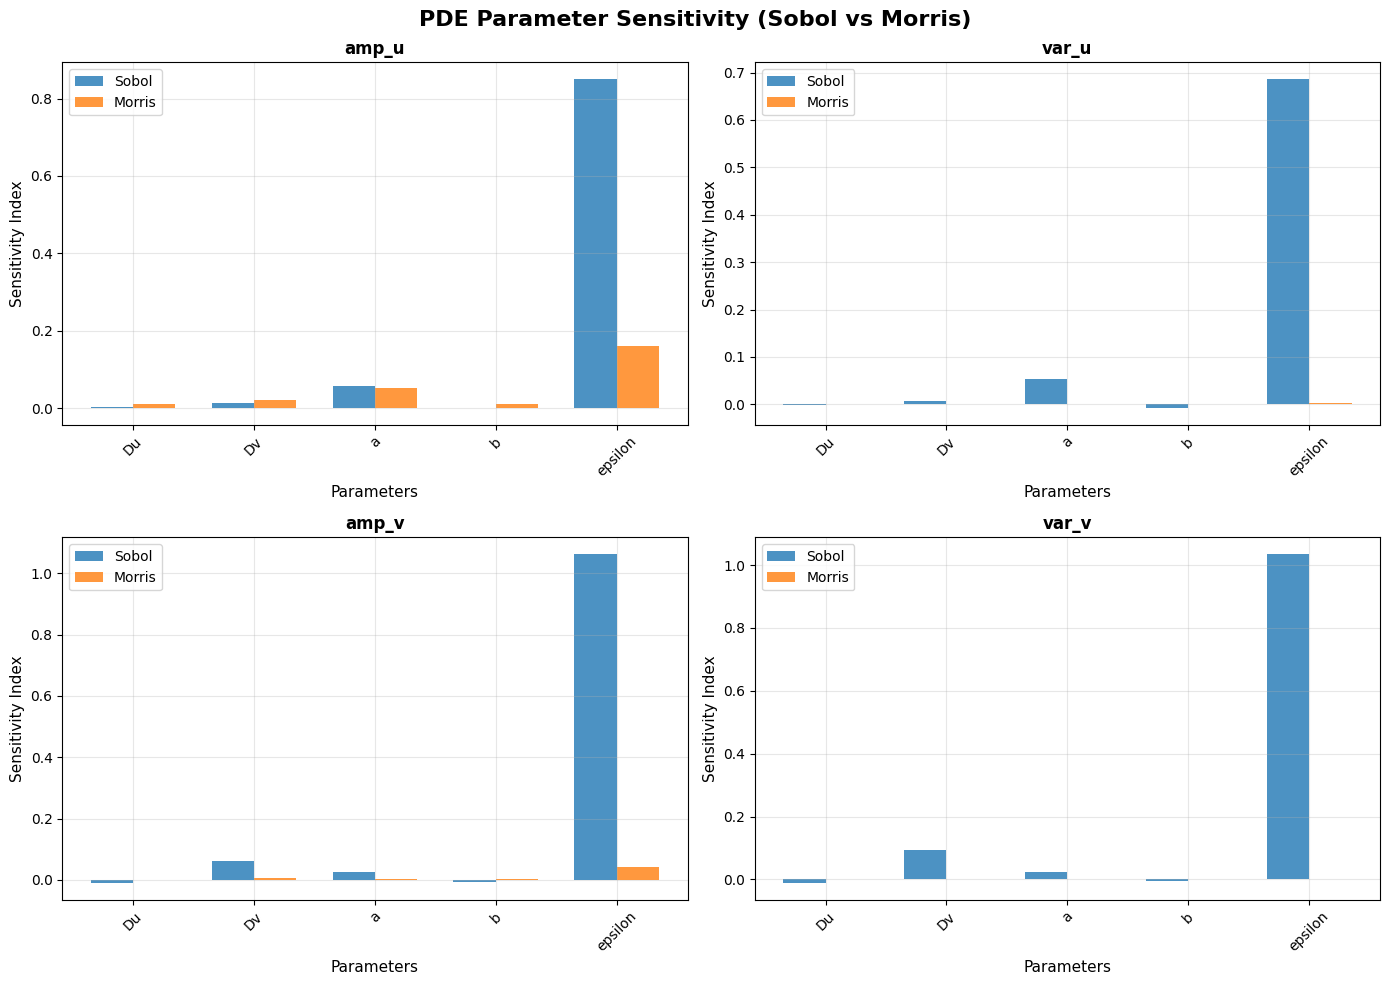

In [103]:
# Create comparison table for PDE sensitivity indices
metrics_list = ['amp_u', 'var_u', 'amp_v', 'var_v']
params_list = problem['names']

# Build dataframe for Sobol S1
sobol_data = []
for metric in metrics_list:
    row = {'Metric': metric, 'Method': 'Sobol'}
    for i, param in enumerate(params_list):
        row[param] = sobol_results[metric]['S1'][i]
    sobol_data.append(row)

# Build dataframe for Morris mu*
morris_data = []
for metric in metrics_list:
    row = {'Metric': metric, 'Method': 'Morris'}
    for i, param in enumerate(params_list):
        row[param] = morris_results[metric]['mu_star'][i]
    morris_data.append(row)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('PDE Parameter Sensitivity (Sobol vs Morris)', fontsize=16, fontweight='bold')

for idx, metric in enumerate(metrics_list):
    ax = axes[idx // 2, idx % 2]
    
    x = np.arange(len(params_list))
    width = 0.35
    
    sobol_vals = sobol_results[metric]['S1']
    morris_vals = morris_results[metric]['mu_star']
    
    ax.bar(x - width/2, sobol_vals, width, label='Sobol', alpha=0.8)
    ax.bar(x + width/2, morris_vals, width, label='Morris', alpha=0.8)
    
    ax.set_xlabel('Parameters', fontsize=11)
    ax.set_ylabel('Sensitivity Index', fontsize=11)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(params_list, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [104]:
# ODE surrogate sensitivity setup
problem_ode = {
    'num_vars': 7,
    'names': ['a','b','epsilon','k1','k2','omega','gamma'],
    'bounds': [
        [0.05, 0.4],   # a threshold
        [0.5, 1.5],    # b recovery weight
        [0.005, 0.15], # epsilon timescale
        [0.5, 2.0],    # k1 coupling to amplitude x
        [0.1, 1.0],    # k2 damping of x
        [0.01, 0.5],   # omega rotation freq
        [0.01, 0.5]    # gamma rotational damping
    ]
}

from scipy.integrate import solve_ivp

def run_ode_and_metrics(params_list, t_end=50.0, t_points=1000):
    def ode_wrapper(t, y):
        return ode_sim(t, y, params_list)

    y0 = [0.1, 0.0, 0.0, 0.0]  # initial conditions
    t_eval = np.linspace(0, t_end, t_points)
    sol = solve_ivp(ode_wrapper, (0, t_end), y0, t_eval=t_eval, method='RK45')
    
    u_series = sol.y[0]
    v_series = sol.y[1]
    x_series = sol.y[2]
    y_series = sol.y[3]
    
    amp_u = u_series.max() - u_series.min()
    var_u = u_series.var()
    amp_v = v_series.max() - v_series.min()
    var_v = v_series.var()
    amp_x = x_series.max() - x_series.min()
    var_x = x_series.var()
    amp_y = y_series.max() - y_series.min()
    var_y = y_series.var()
    
    return amp_u, var_u, amp_v, var_v, amp_x, var_x, amp_y, var_y

def evaluate_ode_samples(X, names):
    amp_u_list = []
    var_u_list = []
    amp_v_list = []
    var_v_list = []
    amp_x_list = []
    var_x_list = []
    amp_y_list = []
    var_y_list = []
    
    for row in X:
        params_list = list(row)
        amp_u, var_u, amp_v, var_v, amp_x, var_x, amp_y, var_y = run_ode_and_metrics(params_list)
        amp_u_list.append(amp_u)
        var_u_list.append(var_u)
        amp_v_list.append(amp_v)
        var_v_list.append(var_v)
        amp_x_list.append(amp_x)
        var_x_list.append(var_x)
        amp_y_list.append(amp_y)
        var_y_list.append(var_y)
        
    return {
        'amp_u': np.array(amp_u_list),
        'var_u': np.array(var_u_list),
        'amp_v': np.array(amp_v_list),
        'var_v': np.array(var_v_list),
        'amp_x': np.array(amp_x_list),
        'var_x': np.array(var_x_list),
        'amp_y': np.array(amp_y_list),
        'var_y': np.array(var_y_list)
    }

In [105]:
# Sobol analysis for ODE surrogate
N_ode = 256  # base sample size (increase for robustness)
X_sobol_ode = saltelli.sample(problem_ode, N_ode, calc_second_order=True)
print(f"Saltelli ODE sample shape: {X_sobol_ode.shape}")

metrics_ode = evaluate_ode_samples(X_sobol_ode, problem_ode['names'])

sobol_ode_results = {}
for metric_name, Yvals in metrics_ode.items():
    Si_metric = sobol.analyze(problem_ode, Yvals, calc_second_order=True, print_to_console=False)
    sobol_ode_results[metric_name] = Si_metric


C:\Users\purch\AppData\Local\Temp\ipykernel_43716\3742086501.py:3: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  X_sobol_ode = saltelli.sample(problem_ode, N_ode, calc_second_order=True)


Saltelli ODE sample shape: (4096, 7)


In [106]:
# Morris analysis for ODE surrogate
num_levels_ode = 6
num_trajectories_ode = 30
X_morris_ode = morris_sampler.sample(problem_ode, N=num_trajectories_ode, num_levels=num_levels_ode)

metrics_morris_ode = evaluate_ode_samples(X_morris_ode, problem_ode['names'])

morris_ode_results = {}
for metric_name, Yvals in metrics_morris_ode.items():
    Mi = morris.analyze(problem_ode, X_morris_ode, Yvals, num_levels=num_levels_ode, print_to_console=False)
    morris_ode_results[metric_name] = Mi


### ODE Sensitivity Visualization

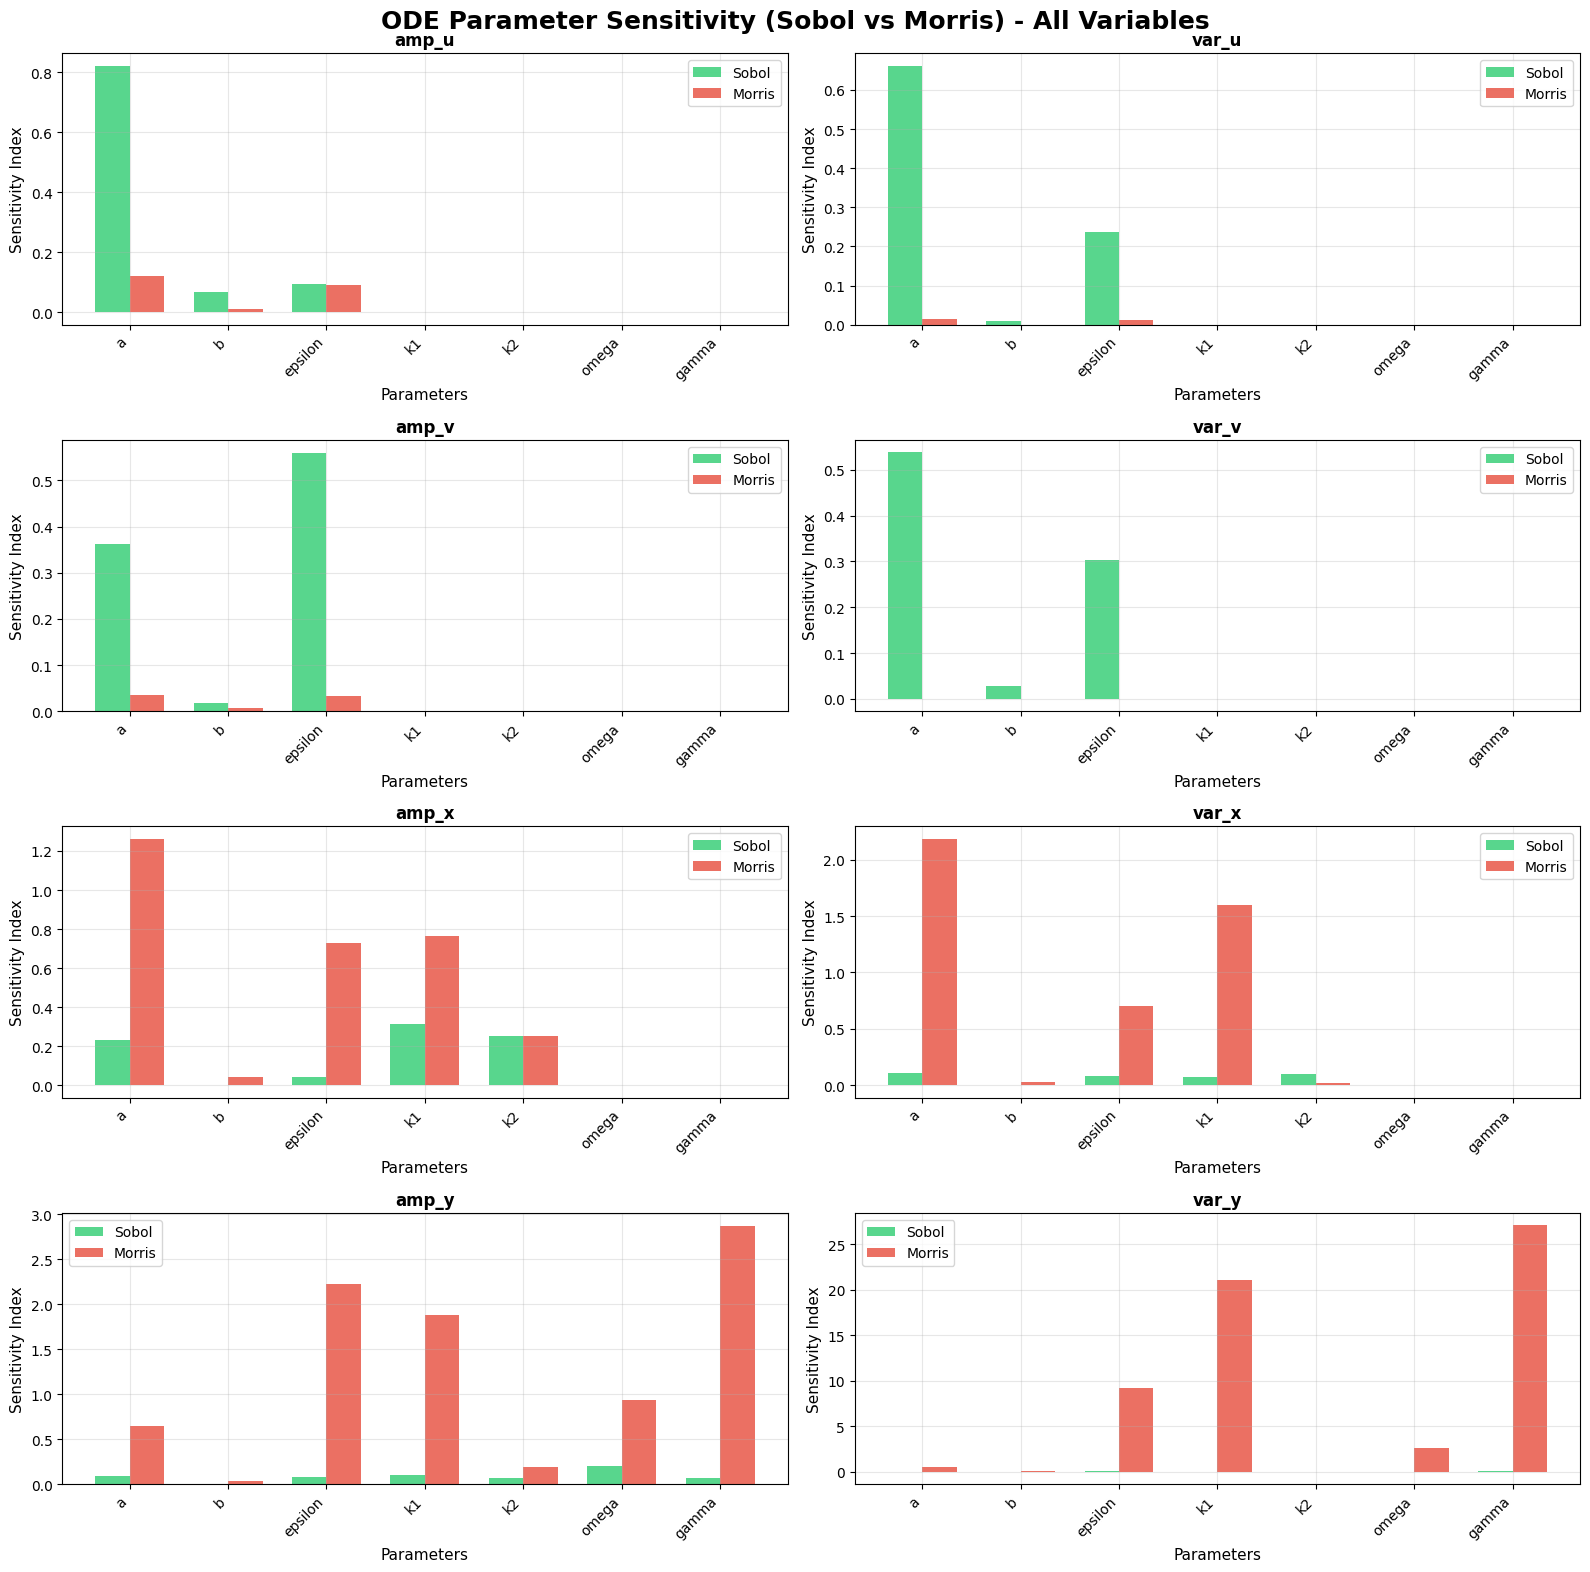

In [107]:
# Create comparison table for ODE sensitivity indices
metrics_ode_list = ['amp_u', 'var_u', 'amp_v', 'var_v', 'amp_x', 'var_x', 'amp_y', 'var_y']
params_ode_list = problem_ode['names']

# Build dataframe for Sobol S1
sobol_ode_data = []
for metric in metrics_ode_list:
    row = {'Metric': metric, 'Method': 'Sobol'}
    for i, param in enumerate(params_ode_list):
        row[param] = sobol_ode_results[metric]['S1'][i]
    sobol_ode_data.append(row)

# Build dataframe for Morris mu*
morris_ode_data = []
for metric in metrics_ode_list:
    row = {'Metric': metric, 'Method': 'Morris'}
    for i, param in enumerate(params_ode_list):
        row[param] = morris_ode_results[metric]['mu_star'][i]
    morris_ode_data.append(row)

# Plot comparison - now 4x2 grid for all 8 metrics
fig, axes = plt.subplots(4, 2, figsize=(16, 16))
fig.suptitle('ODE Parameter Sensitivity (Sobol vs Morris) - All Variables', fontsize=18, fontweight='bold')

for idx, metric in enumerate(metrics_ode_list):
    ax = axes[idx // 2, idx % 2]
    
    x = np.arange(len(params_ode_list))
    width = 0.35
    
    sobol_vals = sobol_ode_results[metric]['S1']
    morris_vals = morris_ode_results[metric]['mu_star']
    
    ax.bar(x - width/2, sobol_vals, width, label='Sobol', alpha=0.8, color='#2ecc71')
    ax.bar(x + width/2, morris_vals, width, label='Morris', alpha=0.8, color='#e74c3c')
    
    ax.set_xlabel('Parameters', fontsize=11)
    ax.set_ylabel('Sensitivity Index', fontsize=11)
    ax.set_title(f'{metric}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(params_ode_list, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Simplified Models & Comparison

In [108]:
problem_pde_simplified = {
    'num_vars': 3,
    'names': ['Dv', 'a', 'epsilon'],
    'bounds': [[0.0, 1.0],
               [0.05, 0.15],
               [0.001, 0.02]]
}

FIXED_DU = 1.0 
FIXED_B = 1.0 

def run_pde_simplified_and_metrics(params: dict, size=60, steps=1600, snapshot_interval=20, solver='euler'):
    full_params = {'Du': FIXED_DU, 'b': FIXED_B, **params}
    
    sim = pde_sim(size=size, solver=solver, **full_params)
    sim.set_initial_conditions('spiral_obstacle')
    
    history_u = []
    history_v = []
    for step in range(steps):
        sim.step()
        if step % snapshot_interval == 0:
            history_u.append(sim.u.mean())
            history_v.append(sim.v.mean())
    
    u_arr = np.array(history_u)
    v_arr = np.array(history_v)
    amp_u = u_arr.max() - u_arr.min()
    amp_v = v_arr.max() - v_arr.min()
    var_u = u_arr.var()
    var_v = v_arr.var()
    
    return amp_u, var_u, amp_v, var_v, u_arr, v_arr

def evaluate_pde_simplified_samples(X, names):
    amp_u_list = []
    var_u_list = []
    amp_v_list = []
    var_v_list = []
    
    for row in X:
        params = dict(zip(names, row))
        amp_u, var_u, amp_v, var_v, _, _ = run_pde_simplified_and_metrics(params)
        amp_u_list.append(amp_u)
        var_u_list.append(var_u)
        amp_v_list.append(amp_v)
        var_v_list.append(var_v)
    
    return {
        'amp_u': np.array(amp_u_list),
        'var_u': np.array(var_u_list),
        'amp_v': np.array(amp_v_list),
        'var_v': np.array(var_v_list)
    }

In [109]:
problem_ode_simplified = {
    'num_vars': 6,
    'names': ['a', 'epsilon', 'k1', 'k2', 'omega', 'gamma'],
    'bounds': [
        [0.05, 0.4],   # a threshold
        [0.005, 0.15], # epsilon timescale
        [0.5, 2.0],    # k1 coupling to amplitude x
        [0.1, 1.0],    # k2 damping of x
        [0.01, 0.5],   # omega rotation freq
        [0.01, 0.5]    # gamma rotational damping
    ]
}

FIXED_B_ODE = 1.0

def fhn_ode_surrogate_simplified(t, y, params):
    u, v, x, y_rot = y
    a, epsilon, k1, k2, omega, gamma = params
    b = FIXED_B_ODE
    
    du_dt = u * (1 - u) * (u - a) - v
    dv_dt = epsilon * (u - b * v)
    dx_dt = k1 * u - k2 * x 
    dy_dt = omega * x - gamma * y_rot 
    
    return [du_dt, dv_dt, dx_dt, dy_dt]

def run_ode_simplified_and_metrics(params_list, t_end=50.0, t_points=1000):
    def ode_wrapper(t, y):
        return fhn_ode_surrogate_simplified(t, y, params_list)

    y0 = [0.1, 0.0, 0.0, 0.0]
    t_eval = np.linspace(0, t_end, t_points)
    sol = solve_ivp(ode_wrapper, (0, t_end), y0, t_eval=t_eval, method='RK45')
    
    u_series = sol.y[0]
    v_series = sol.y[1]
    x_series = sol.y[2]
    y_series = sol.y[3]
    
    amp_u = u_series.max() - u_series.min()
    var_u = u_series.var()
    amp_v = v_series.max() - v_series.min()
    var_v = v_series.var()
    amp_x = x_series.max() - x_series.min()
    var_x = x_series.var()
    amp_y = y_series.max() - y_series.min()
    var_y = y_series.var()
    
    return amp_u, var_u, amp_v, var_v, amp_x, var_x, amp_y, var_y, sol

def evaluate_ode_simplified_samples(X, names):
    amp_u_list = []
    var_u_list = []
    amp_v_list = []
    var_v_list = []
    amp_x_list = []
    var_x_list = []
    amp_y_list = []
    var_y_list = []
    
    for row in X:
        params_list = list(row)
        amp_u, var_u, amp_v, var_v, amp_x, var_x, amp_y, var_y, _ = run_ode_simplified_and_metrics(params_list)
        amp_u_list.append(amp_u)
        var_u_list.append(var_u)
        amp_v_list.append(amp_v)
        var_v_list.append(var_v)
        amp_x_list.append(amp_x)
        var_x_list.append(var_x)
        amp_y_list.append(amp_y)
        var_y_list.append(var_y)
        
    return {
        'amp_u': np.array(amp_u_list),
        'var_u': np.array(var_u_list),
        'amp_v': np.array(amp_v_list),
        'var_v': np.array(var_v_list),
        'amp_x': np.array(amp_x_list),
        'var_x': np.array(var_x_list),
        'amp_y': np.array(amp_y_list),
        'var_y': np.array(var_y_list)
    }


### Comparison: Original vs Simplified PDE Model

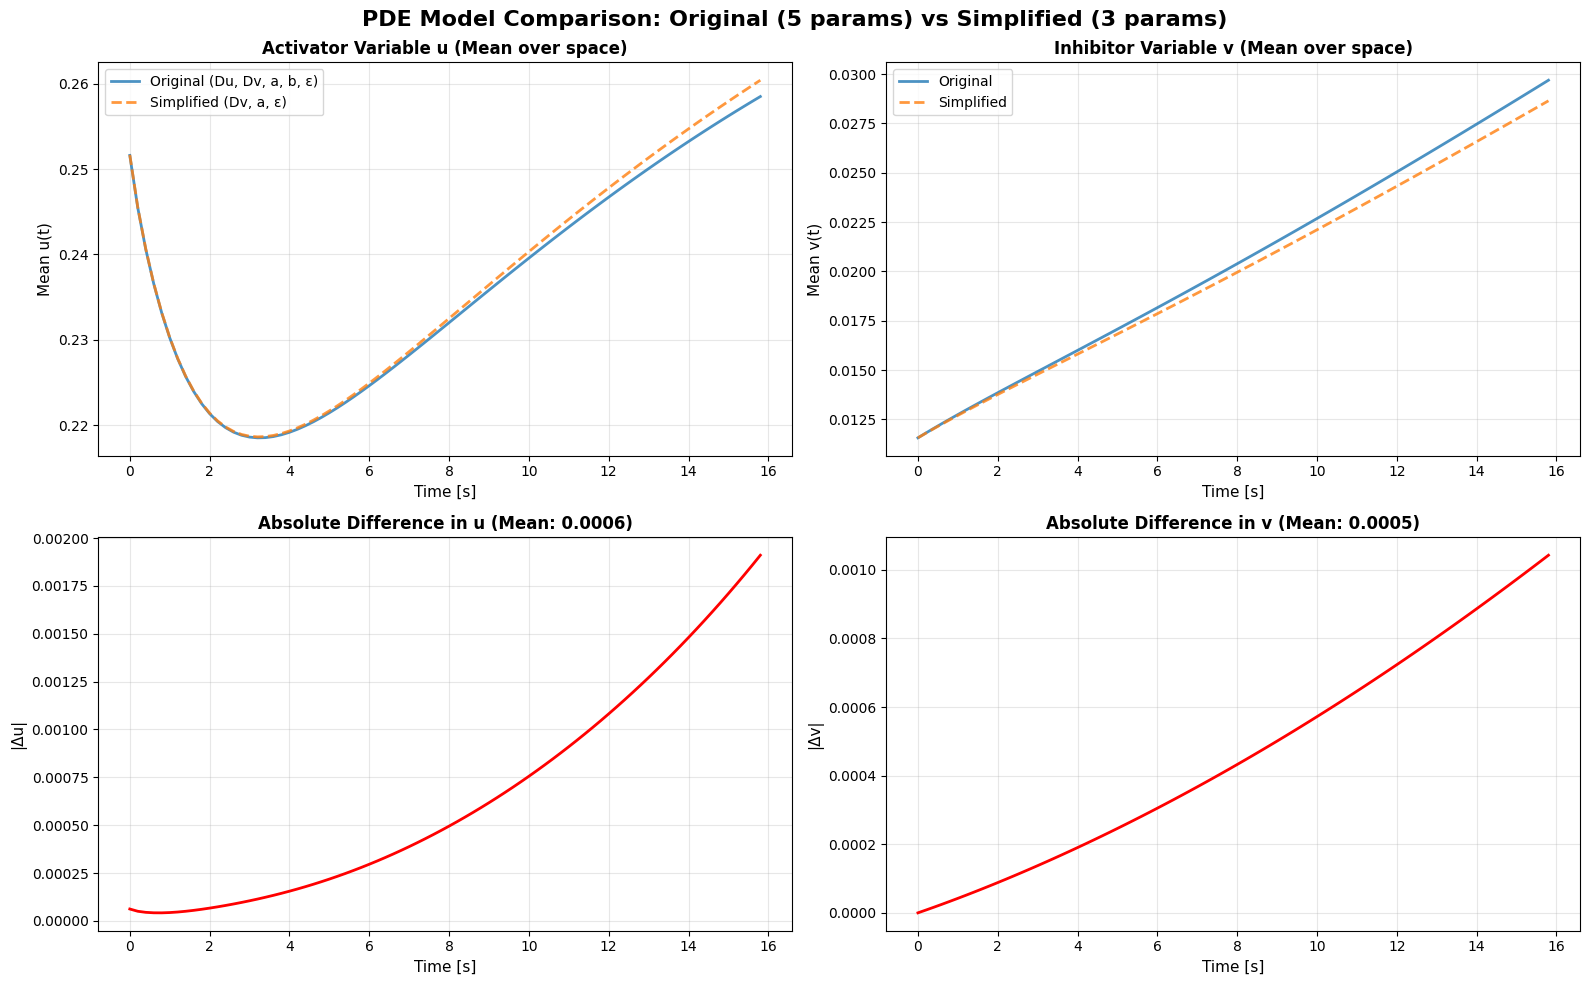

In [110]:

test_params_pde = {
    'Dv': 0.0,
    'a': 0.05,
    'epsilon': 0.005
}

full_params_original = {
    'Du': 1.0,  
    'b': 0.3,   
    **test_params_pde
}

_, _, _, _, u_original, v_original = run_pde_and_metrics(full_params_original, size=60, steps=1600, snapshot_interval=20)

_, _, _, _, u_simplified, v_simplified = run_pde_simplified_and_metrics(test_params_pde, size=60, steps=1600, snapshot_interval=20)

time_pde = np.arange(len(u_original)) * 20 * 0.01  # steps * snapshot_interval * dt

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('PDE Model Comparison: Original (5 params) vs Simplified (3 params)', fontsize=16, fontweight='bold')

# U variable - amplitude
ax1 = axes[0, 0]
ax1.plot(time_pde, u_original, label='Original (Du, Dv, a, b, ε)', linewidth=2, alpha=0.8)
ax1.plot(time_pde, u_simplified, label='Simplified (Dv, a, ε)', linewidth=2, linestyle='--', alpha=0.8)
ax1.set_xlabel('Time [s]', fontsize=11)
ax1.set_ylabel('Mean u(t)', fontsize=11)
ax1.set_title('Activator Variable u (Mean over space)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# V variable - amplitude
ax2 = axes[0, 1]
ax2.plot(time_pde, v_original, label='Original', linewidth=2, alpha=0.8)
ax2.plot(time_pde, v_simplified, label='Simplified', linewidth=2, linestyle='--', alpha=0.8)
ax2.set_xlabel('Time [s]', fontsize=11)
ax2.set_ylabel('Mean v(t)', fontsize=11)
ax2.set_title('Inhibitor Variable v (Mean over space)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Difference plots
ax3 = axes[1, 0]
diff_u = np.abs(u_original - u_simplified)
ax3.plot(time_pde, diff_u, color='red', linewidth=2)
ax3.set_xlabel('Time [s]', fontsize=11)
ax3.set_ylabel('|Δu|', fontsize=11)
ax3.set_title(f'Absolute Difference in u (Mean: {diff_u.mean():.4f})', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
diff_v = np.abs(v_original - v_simplified)
ax4.plot(time_pde, diff_v, color='red', linewidth=2)
ax4.set_xlabel('Time [s]', fontsize=11)
ax4.set_ylabel('|Δv|', fontsize=11)
ax4.set_title(f'Absolute Difference in v (Mean: {diff_v.mean():.4f})', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate error metrics
mse_u = np.mean((u_original - u_simplified)**2)
mse_v = np.mean((v_original - v_simplified)**2)
mae_u = np.mean(np.abs(u_original - u_simplified))
mae_v = np.mean(np.abs(v_original - v_simplified))


### Comparison: Original vs Simplified ODE Model

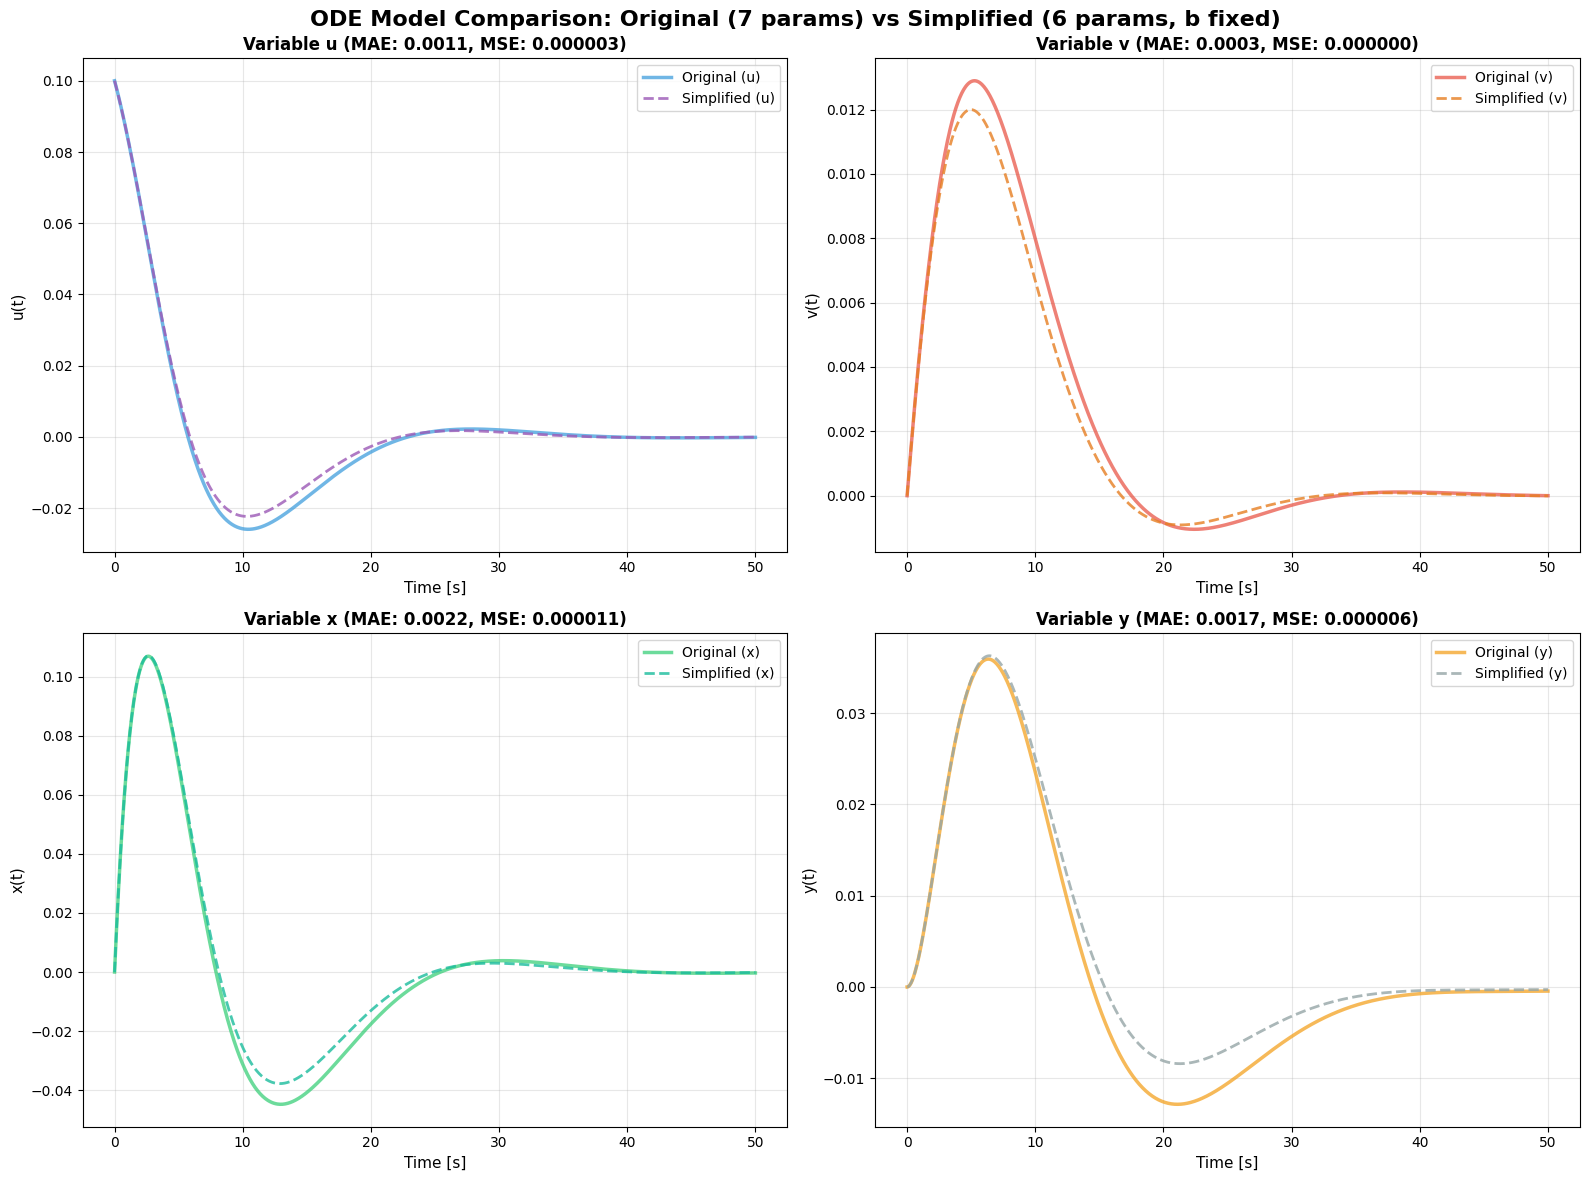

In [113]:

test_params_ode_simplified = [
    0.25,  # a
    0.05,  # epsilon
    1.0,   # k1
    0.5,   # k2
    0.1,   # omega
    0.1    # gamma
]

test_params_ode_original = [
    0.25,  # a
    0.5,   # b
    0.05,  # epsilon
    1.0,   # k1
    0.5,   # k2
    0.1,   # omega
    0.1    # gamma
]

t_end = 50.0
t_points = 1000
t_eval = np.linspace(0, t_end, t_points)

# Original ODE
def ode_wrapper_original(t, y):
    return ode_sim(t, y, test_params_ode_original)

y0 = [0.1, 0.0, 0.0, 0.0]
sol_original = solve_ivp(ode_wrapper_original, (0, t_end), y0, t_eval=t_eval, method='RK45')

# Simplified ODE
_, _, _, _, _, _, _, _, sol_simplified = run_ode_simplified_and_metrics(test_params_ode_simplified, t_end=t_end, t_points=t_points)

# Plot comparison for all 4 variables
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ODE Model Comparison: Original (7 params) vs Simplified (6 params, b fixed)', fontsize=16, fontweight='bold')

variables = ['u', 'v', 'x', 'y']
colors_orig = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
colors_simp = ['#9b59b6', '#e67e22', '#1abc9c', '#95a5a6']

for idx, var_name in enumerate(variables):
    ax = axes[idx // 2, idx % 2]
    
    original_series = sol_original.y[idx]
    simplified_series = sol_simplified.y[idx]
    
    ax.plot(sol_original.t, original_series, 
            label=f'Original ({var_name})', linewidth=2.5, alpha=0.7, color=colors_orig[idx])
    ax.plot(sol_simplified.t, simplified_series, 
            label=f'Simplified ({var_name})', linewidth=2, linestyle='--', alpha=0.8, color=colors_simp[idx])
    
    # Calculate and display error
    mse = np.mean((original_series - simplified_series)**2)
    mae = np.mean(np.abs(original_series - simplified_series))
    
    ax.set_xlabel('Time [s]', fontsize=11)
    ax.set_ylabel(f'{var_name}(t)', fontsize=11)
    ax.set_title(f'Variable {var_name} (MAE: {mae:.4f}, MSE: {mse:.6f})', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


for idx, var_name in enumerate(variables):
    original_series = sol_original.y[idx]
    simplified_series = sol_simplified.y[idx]
    
    mse = np.mean((original_series - simplified_series)**2)
    mae = np.mean(np.abs(original_series - simplified_series))
    max_abs_error = np.max(np.abs(original_series - simplified_series))
    
    var_range = original_series.max() - original_series.min()
    rel_error = (mae / var_range) * 100 if var_range > 1e-10 else 0


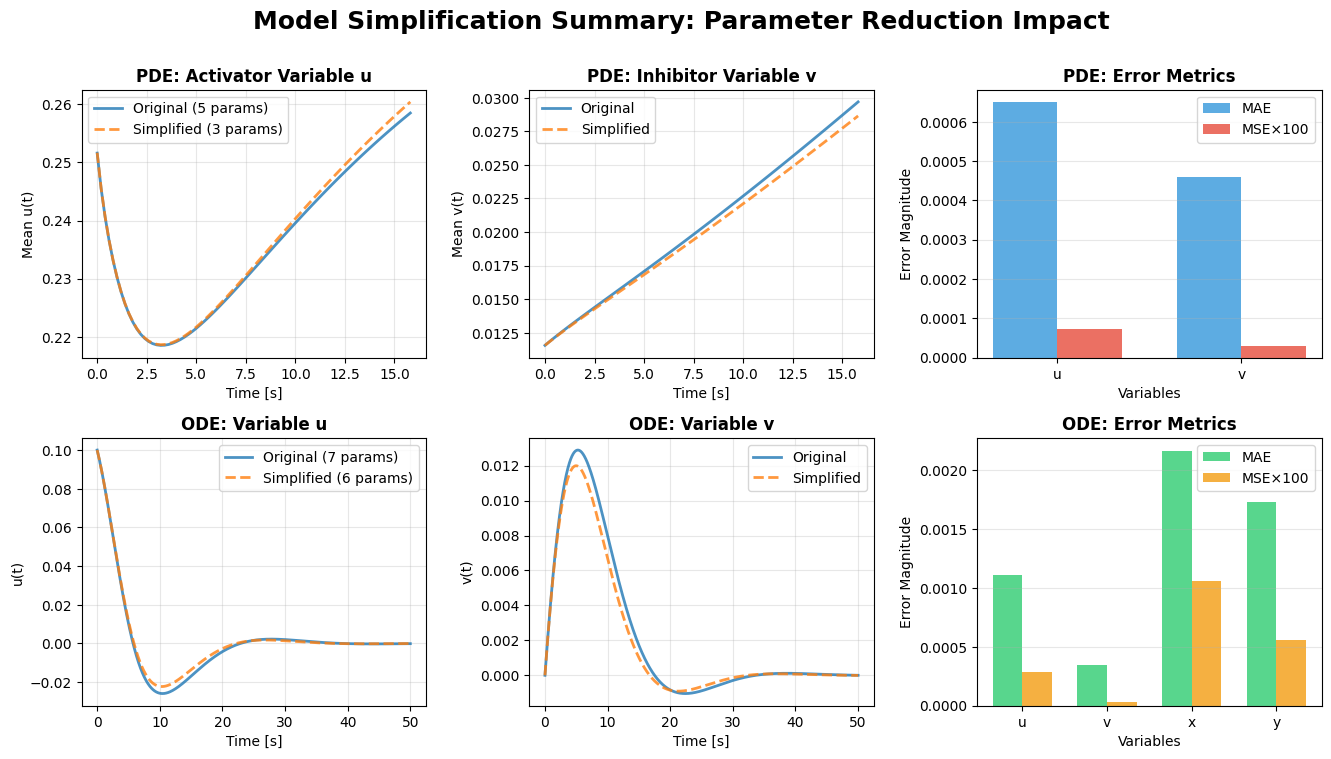

In [112]:
# Summary comparison visualization
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Model Simplification Summary: Parameter Reduction Impact', fontsize=18, fontweight='bold')

# PDE comparison - u variable
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(time_pde, u_original, label='Original (5 params)', linewidth=2, alpha=0.8)
ax1.plot(time_pde, u_simplified, label='Simplified (3 params)', linewidth=2, linestyle='--', alpha=0.8)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Mean u(t)')
ax1.set_title('PDE: Activator Variable u', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# PDE comparison - v variable
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(time_pde, v_original, label='Original', linewidth=2, alpha=0.8)
ax2.plot(time_pde, v_simplified, label='Simplified', linewidth=2, linestyle='--', alpha=0.8)
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Mean v(t)')
ax2.set_title('PDE: Inhibitor Variable v', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# PDE error summary
ax3 = fig.add_subplot(gs[0, 2])
pde_vars = ['u', 'v']
pde_mae = [mae_u, mae_v]
pde_mse = [mse_u, mse_v]

x_pos = np.arange(len(pde_vars))
width = 0.35

ax3.bar(x_pos - width/2, pde_mae, width, label='MAE', alpha=0.8, color='#3498db')
ax3.bar(x_pos + width/2, [m*100 for m in pde_mse], width, label='MSE×100', alpha=0.8, color='#e74c3c')
ax3.set_xlabel('Variables')
ax3.set_ylabel('Error Magnitude')
ax3.set_title('PDE: Error Metrics', fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(pde_vars)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# ODE comparison - u variable
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(sol_original.t, sol_original.y[0], label='Original (7 params)', linewidth=2, alpha=0.8)
ax4.plot(sol_simplified.t, sol_simplified.y[0], label='Simplified (6 params)', linewidth=2, linestyle='--', alpha=0.8)
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('u(t)')
ax4.set_title('ODE: Variable u', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# ODE comparison - v variable
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(sol_original.t, sol_original.y[1], label='Original', linewidth=2, alpha=0.8)
ax5.plot(sol_simplified.t, sol_simplified.y[1], label='Simplified', linewidth=2, linestyle='--', alpha=0.8)
ax5.set_xlabel('Time [s]')
ax5.set_ylabel('v(t)')
ax5.set_title('ODE: Variable v', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# ODE error summary
ax6 = fig.add_subplot(gs[1, 2])
ode_mae_values = []
ode_mse_values = []
for idx in range(4):
    original_series = sol_original.y[idx]
    simplified_series = sol_simplified.y[idx]
    ode_mae_values.append(np.mean(np.abs(original_series - simplified_series)))
    ode_mse_values.append(np.mean((original_series - simplified_series)**2))

x_pos_ode = np.arange(4)
width = 0.35

ax6.bar(x_pos_ode - width/2, ode_mae_values, width, label='MAE', alpha=0.8, color='#2ecc71')
ax6.bar(x_pos_ode + width/2, [m*100 for m in ode_mse_values], width, label='MSE×100', alpha=0.8, color='#f39c12')
ax6.set_xlabel('Variables')
ax6.set_ylabel('Error Magnitude')
ax6.set_title('ODE: Error Metrics', fontweight='bold')
ax6.set_xticks(x_pos_ode)
ax6.set_xticklabels(['u', 'v', 'x', 'y'])
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.show()